<a href="https://colab.research.google.com/github/rajanieprabha/talks-webinars/blob/main/XAI_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

This tutorial shows how to classify images of flowers. It creates an image classifier using a `keras.Sequential` model, and loads data using `preprocessing.image_dataset_from_directory`. You will gain practical experience with the following concepts:

* Efficiently loading a dataset off disk.
* Training a model and visualizing the results with heatmaps.

## Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import PIL
import random
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn.decomposition import PCA

import seaborn as sns

# !pip install chart_studio 
# !pip install plotly
import plotly as py
import plotly.graph_objs as go
import plotly.express as px

## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains 5 sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Here are some roses:

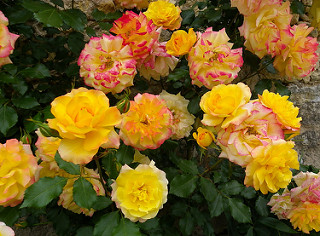

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[random.randint(0, 500)]))

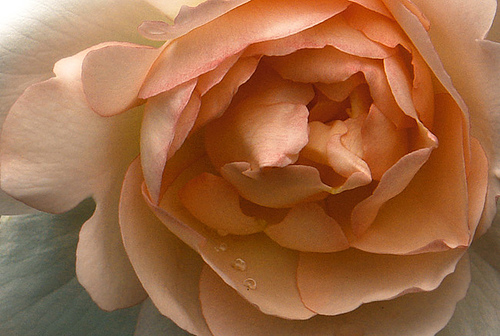

In [6]:
PIL.Image.open(str(roses[random.randint(0, 500)]))

And some tulips:

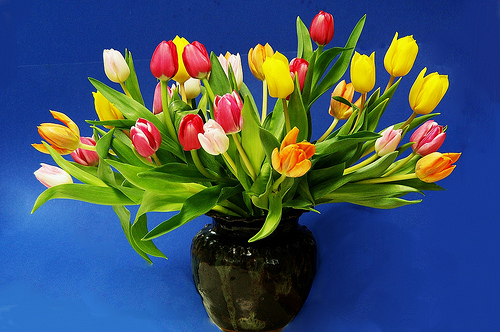

In [7]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[random.randint(0, 500)]))

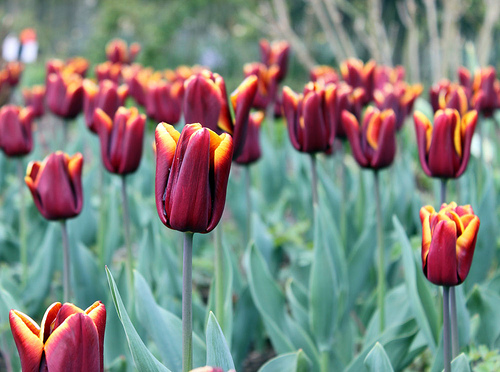

In [ ]:
PIL.Image.open(str(tulips[random.randint(0, 500)]))

# Load using keras.preprocessing

Let's load these images off disk using the helpful [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [load images](https://www.tensorflow.org/tutorials/load_data/images) tutorial.

## Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [12]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [13]:
images = []
labels = []
for image_batch, labels_batch in train_ds:
  images.append(image_batch)
  labels.extend(labels_batch)

images = np.vstack(images)
labels = np.array(labels)
print(images.shape)
print(labels.shape)


(2936, 180, 180, 3)
(2936,)


## PCA

Principal component analysis is a technique for feature extraction — so it combines our input variables in a specific way, then we can drop the “least important” variables while still retaining the most valuable parts of all of the variables! As an added benefit, each of the “new” variables after PCA are all independent of one another.

In [14]:
images = images.reshape(2936,-1)
images = images / 255.0
images = images[:1500]
labels = labels[:1500]
print(images.shape)

(1500, 97200)


In [15]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

variance = 0.98

time_start = time.time()
pca = PCA(variance)

pca_result = pca.fit_transform(images)
# df['pca-one'] = pca_result[:,0]
# df['pca-two'] = pca_result[:,1] 
# df['pca-three'] = pca_result[:,2]

print("Number of components before PCA  = " + str(images.shape[1]))
print("Number of components after PCA 0.98 = " + str(pca.n_components_)) 

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))

PCA_components = pd.DataFrame(pca_result)

Number of components before PCA  = 97200
Number of components after PCA 0.98 = 1009
Explained variation per principal component: [2.2462603e-01 7.2244115e-02 6.1870713e-02 ... 7.0899121e-05 7.0821217e-05
 7.0643822e-05]
PCA done! Time elapsed: 45.07116341590881 seconds


([<matplotlib.axis.XTick at 0x7f53902ea510>,
 <a list of 10 Text major ticklabel objects>)

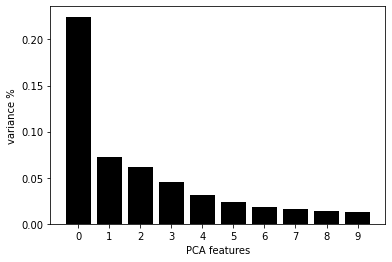

In [16]:
features = range(pca.n_components_)
plt.bar(features[:10], pca.explained_variance_ratio_[:10], color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features[:10])



In [17]:

images = pca.transform(images)
print(images.shape)

(1500, 1009)


In [ ]:
#@title PCA plot
from sklearn.cluster import KMeans
k_means = KMeans(n_clusters = 5, n_init = 35)
k_means.fit(images)

k_means_labels = k_means.labels_ #List of labels of each dataset
print("The list of labels of the clusters are " + str(np.unique(k_means_labels)))


G = len(np.unique(k_means_labels)) #Number of labels

#2D matrix  for an array of indexes of the given label
cluster_index= [[] for i in range(G)]
for i, label in enumerate(k_means_labels,0):
    for n in range(G):
        if label == n:
            cluster_index[n].append(i)
        else:
            continue
class_names = {0:'daisy', 1:'dandelion',2: 'roses',3: 'sunflowers',4: 'tulips'} #Dictionary of class names

k_means_cluster_centers = k_means.cluster_centers_ #numpy array of cluster centers
k_means_cluster_centers.shape #comes from 10 clusters and 420 features

#3D Plotly Visualization of Clusters using go
layout = go.Layout(
    title='<b>Cluster Visualisation</b>',
    yaxis=dict(
        title='<i>Y</i>'
    ),
    xaxis=dict(
        title='<i>X</i>'
    )
)
colors = ['red','green' ,'blue','yellow','cyan']
trace = [ go.Scatter3d() for _ in range(5)]
for i in range(0,5):
    my_members = (k_means_labels == i)
    index = [h for h, g in enumerate(my_members) if g]
    trace[i] = go.Scatter3d(
            x=images[my_members, 0],
            y=images[my_members, 1],
            z=images[my_members, 2],
            mode='markers',
            marker = dict(size = 3,color = colors[i]),
            hovertext=index,
            name=class_names[i],
   
            )
fig = go.Figure(data=[trace[0],trace[1],trace[2],trace[3],trace[4]], layout=layout)
    
py.offline.iplot(fig)

The list of labels of the clusters are [0 1 2 3 4]


In [ ]:
#@title Default title text
# plt.figure(figsize=(10,10))
# sns.set_style("whitegrid")
# sns.scatterplot(
#     x=pca_result[:,0], y=pca_result[:,1] ,
#     hue=labels,
#     palette=sns.color_palette("hls", 5),
#     legend="full",
#     alpha=1,
# )

# #plt.legend(title='Flowers', loc='upper right', labels=['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'])

# ax = plt.figure(figsize=(16,10)).gca(projection='3d')
# ax.scatter(
#     xs=pca_result[:,2], 
#     ys=pca_result[:,0], 
#     zs=pca_result[:,1], 
#     c=labels, 
#     cmap='tab10'
# )
# ax.set_xlabel('pca-one')
# ax.set_ylabel('pca-two')
# ax.set_zlabel('pca-three')
# plt.show()

You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [18]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

Here are the first 9 images from the training dataset.

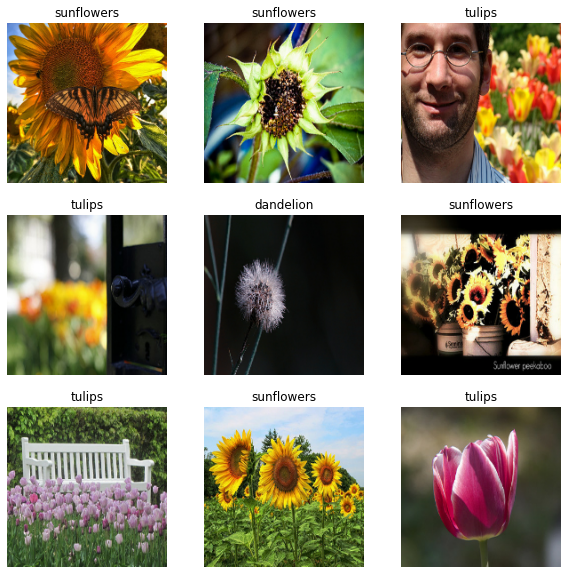

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will train a model using these datasets by passing them to `model.fit` in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [20]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images. 

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training. 

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the `[0, 1]` range by using a Rescaling layer.

In [22]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

Note: The Keras Preprocessing utilities and layers introduced in this section are currently experimental and may change.

There are two ways to use this layer. You can apply it to the dataset by calling map:

In [23]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

Note: you previously resized images using the `image_size` argument of `image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the [Resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the layers from `tf.keras.layers.experimental.preprocessing`. These can be included inside your model like other layers, and run on the GPU.

In [24]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

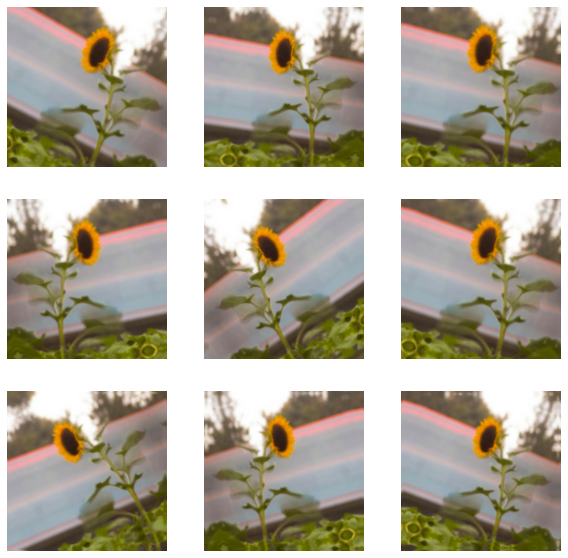

In [25]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will use data augmentation to train a model in a moment.

# Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function. This model has not been tuned for high accuracy, the goal of this tutorial is to show a standard approach. 

In [26]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(5)
])

## Compile and train the model

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)       

In [29]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
92/92 [==============================] - 11s 37ms/step - loss: 1.4714 - accuracy: 0.3450 - val_loss: 1.2516 - val_accuracy: 0.4183
Epoch 2/20
92/92 [==============================] - 2s 22ms/step - loss: 1.0906 - accuracy: 0.5698 - val_loss: 1.0142 - val_accuracy: 0.6049
Epoch 3/20
92/92 [==============================] - 2s 22ms/step - loss: 0.9664 - accuracy: 0.6236 - val_loss: 1.0147 - val_accuracy: 0.6213
Epoch 4/20
92/92 [==============================] - 2s 22ms/step - loss: 0.8748 - accuracy: 0.6529 - val_loss: 0.9063 - val_accuracy: 0.6335
Epoch 5/20
92/92 [==============================] - 2s 22ms/step - loss: 0.8411 - accuracy: 0.6730 - val_loss: 0.8855 - val_accuracy: 0.6226
Epoch 6/20
92/92 [==============================] - 2s 21ms/step - loss: 0.7950 - accuracy: 0.6887 - val_loss: 0.8335 - val_accuracy: 0.6771
Epoch 7/20
92/92 [==============================] - 2s 22ms/step - loss: 0.7500 - accuracy: 0.7122 - val_loss: 0.7737 - val_accuracy: 0.6812
Epoch 8/20
9

## Visualize training results

After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned. 

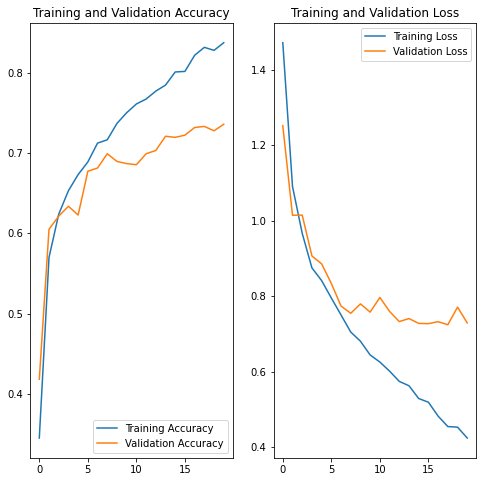

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and Dropout layers are inactive at inference time.

In [31]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to sunflowers with a 99.65 percent confidence.


In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)       

In [34]:
#@title Heatmaps functions
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


This image most likely belongs to sunflowers with a 99.65 percent confidence.


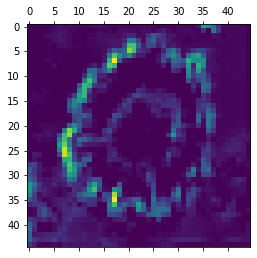

In [35]:


sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(model)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

# Remove last layer's softmax
#model.layers[-1].activation = None
last_conv_layer_name = "conv2d_2"

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

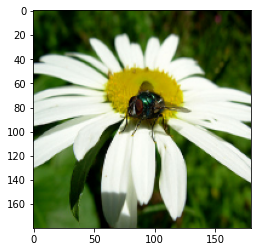

This image most likely belongs to daisy with a 100.00 percent confidence.


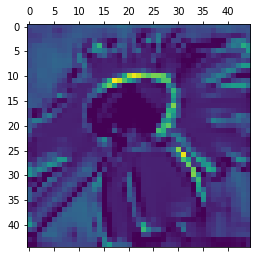

In [39]:
from matplotlib import pyplot as plt
images = []
labels = []
for image_batch, labels_batch in train_ds:
  images.append(image_batch)
  labels.extend(labels_batch)

images = np.vstack(images)
labels = np.array(labels)

x = random.randint(0, 2500)

plt.imshow(images[x].astype("uint8"))
plt.show()

img_array = tf.expand_dims(images[x], 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(model)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

# Remove last layer's softmax
#model.layers[-1].activation = None
last_conv_layer_name = "conv2d_2"

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

## TSNE PLOT

t-Distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised, non-linear technique primarily used for data exploration and visualizing high-dimensional data. In simpler terms, t-SNE gives you a feel or intuition of how the data is arranged in a high-dimensional space. It was developed by Laurens van der Maatens and Geoffrey Hinton in 2008.

In [ ]:
from sklearn.manifold import TSNE

images = []
labels = []
for image_batch, labels_batch in train_ds:
  images.append(image_batch)
  labels.extend(labels_batch)
  

images = np.vstack(images)
labels = np.array(labels)
print(images.shape)
print(labels.shape)

images = images.reshape(2936,-1)
images = images / 255.0
print(images.shape)

time_start = time.time()
tsne = TSNE(n_components=2, verbose=2, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(images)

print(tsne_results)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


(2936, 180, 180, 3)
(2936,)
(2936, 97200)
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2936 samples in 26.209s...
[t-SNE] Computed neighbors for 2936 samples in 1543.998s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2936
[t-SNE] Computed conditional probabilities for sample 2000 / 2936
[t-SNE] Computed conditional probabilities for sample 2936 / 2936
[t-SNE] Mean sigma: 22.059421
[t-SNE] Computed conditional probabilities in 0.323s
[t-SNE] Iteration 50: error = 89.3718033, gradient norm = 0.2164484 (50 iterations in 1.617s)
[t-SNE] Iteration 100: error = 90.9000092, gradient norm = 0.2016551 (50 iterations in 1.377s)
[t-SNE] Iteration 150: error = 94.0505447, gradient norm = 0.1774092 (50 iterations in 1.336s)
[t-SNE] Iteration 200: error = 93.2290955, gradient norm = 0.1720736 (50 iterations in 1.458s)
[t-SNE] Iteration 250: error = 94.2040100, gradient norm = 0.1989141 (50 iterations in 1.434s)
[t-SNE] KL divergence after 250 iterations with early exa

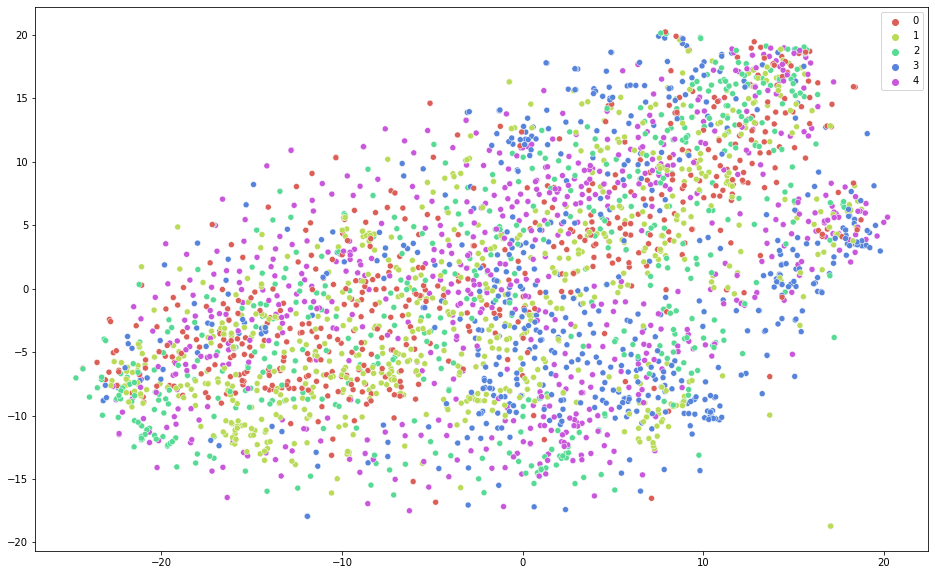

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=labels,
    palette=sns.color_palette("hls", 5),
    legend="full",
    alpha=1
)